# Entendimento do Problema

Objetivo do Problema:
- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.
    - Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace (Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta (pessoas oferecendo acomodacao)
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda (pessoas procurando acomodacao)
            - Numero de Usuários
            - LTV (Lifetime Value)
            - CAC (Client Acquisition Cost)
            
            
           Gross Revenue = (Fee*Numero cliente) - CAC 

- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**

# 0.0 Imports

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
from scipy import stats as ss

from keras import models as ml
from keras import layers as l

from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from imblearn import combine as c

from pandas_profiling import ProfileReport

from category_encoders import TargetEncoder, OneHotEncoder

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [2]:
warnings.filterwarnings('always')

##  0.1. Helper Functions

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

##  0.2. Carregando dados

In [4]:
df_raw = pd.read_csv('../dados/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [5]:
df_sessions = pd.read_csv('../dados/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0. Descrição dos Dados

In [6]:
df1 = df_raw.copy()

## 1.1. Dimensão dos Dados

In [7]:
print('Usuários Número de Linhas: {}'.format(df1.shape[0]))
print('Usuários Número de Colunas: {}'.format(df1.shape[1]))

Usuários Número de Linhas: 213451
Usuários Número de Colunas: 16


In [8]:
print('Usuários Número de Linhas: {}'.format(df_sessions.shape[0]))
print('Usuários Número de Colunas: {}'.format(df_sessions.shape[1]))

Usuários Número de Linhas: 10567737
Usuários Número de Colunas: 6


##  1.2. Tipo Dados

In [9]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [10]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NA

In [11]:
df1.isna().sum() / len(df1) * 100

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

In [12]:
df_sessions.isna().sum() / len(df_sessions) * 100

user_id           0.326428
action            0.753482
action_type      10.657003
action_detail    10.657003
device_type       0.000000
secs_elapsed      1.287229
dtype: float64

In [13]:
# Dataset Usuário

# date_first_booking_max
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

In [14]:
# Dataset Sessions
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [15]:
df1.isna().sum() / len(df1) * 100

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [16]:
df_sessions.isna().sum() / len(df_sessions) * 100

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.4. Mudando dTyepes

In [17]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [18]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

## 1.5. Valida Balanceamento

In [19]:
df1['country_destination'].value_counts(normalize=True) * 100

NDF      44.727486
US       39.186699
other     6.124629
FR        2.991781
IT        1.642258
GB        1.433511
ES        1.373985
CA        0.867608
DE        0.685769
NL        0.485176
AU        0.353077
PT        0.128021
Name: country_destination, dtype: float64

## 1.6. Análise descritiva

In [20]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

In [21]:
def get_analise_descritiva(df):
    d0 = df.describe()
    d1 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d2 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T
    d3 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    ct = pd.concat([d0, d3, d1, d2]).T.reset_index()
    ct.columns = ['Atributos', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'skew', 'kurtosis']
    return ct

### 1.6.1. Númerico - Users

In [22]:
get_analise_descritiva(num_attributes)

,Atributos,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,age,122636.0,37.405591,13.939900,16.0,28.0,34.0,43.0,115.0,99.0,2.089718,6.516468
1,signup_flow,122636.0,2.519513,6.604723,0.0,0.0,0.0,0.0,25.0,25.0,2.705871,5.928298


### 1.6.2. Númerico - Sessions

In [23]:
get_analise_descritiva(num_attributes_sessions)

,Atributos,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,secs_elapsed,9213930.0,19961.8251,88849.39327,0.0,333.0,1369.0,9796.0,1799977.0,1799977.0,11.137761,154.84312


### 1.6.3. Categórico - Users

In [24]:
cat_attributes.drop('id', axis=1).describe() 

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4. Categórico - Sessions

In [25]:
cat_attributes_sessions.drop('user_id', axis=1).describe() 

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [26]:
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len (cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

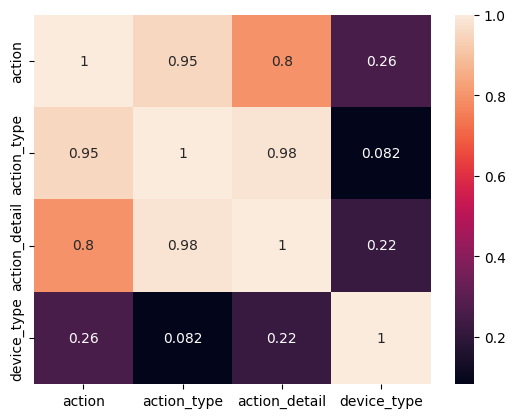

In [27]:
tmp = pd.DataFrame(corr_dict)
tmp = tmp.set_index(tmp.columns)
sns.heatmap(tmp, annot=True)

# 2.0. Feature Engineering

In [28]:
df2 = df1.copy()
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 2.1. Criando Novas Features

In [29]:
# dias desde o primeiro ativo até a primeira reserva
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

# dias desde a primeira ativação até a conta criada
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

# dias desde a criação da conta até a primeira reserva
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

# ================== Primeira Ativação ==================
df2['year_first_active'] = df2['first_active'].dt.year
df2['month_first_active'] = df2['first_active'].dt.month
df2['day_first_active'] = df2['first_active'].dt.day
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week

# # ================== Primeira reserva ==================
df2['year_first_booking'] = df2['date_first_booking'].dt.year
df2['month_first_booking'] = df2['date_first_booking'].dt.month
df2['day_first_booking'] = df2['date_first_booking'].dt.day
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.isocalendar().week

# # ================== Conta Criada =================
df2['year_account_created'] = df2['date_account_created'].dt.year
df2['month_account_created'] = df2['date_account_created'].dt.month
df2['day_account_created'] = df2['date_account_created'].dt.day
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek
df2['week_of_year_account_created'] = df2['date_account_created'].dt.isocalendar().week

In [30]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2010,2,18,3,7,2010,9,14,1,37
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,...,2010,1,5,1,1,2010,1,2,5,53


# 3.0. Filtragem Dados

In [31]:
df3 = df2.copy()

## 3.1. Filtragem Linhas

In [32]:
# Filtrando Idade maior que 15 e menor que 120 anos.
df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

## 3.2. Seleção Colunas

In [33]:
cols = ['date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active']
df3 = df3.drop(cols, axis=1)

# 4.0. Preparação Dados

In [34]:
df4 = df3.copy()

## 4.1. Balanceamento Dataset

In [35]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[ col_cat]).toarray(), index=df4.index)

# join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)
df42.shape

(122636, 391)

### 4.1.1. Random Undersampling

In [36]:
 # ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

# apply sampler
X_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [37]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [38]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

### 4.1.2. Random Oversampling

In [39]:
# ratio_balanced
#ratio_balanced = {'NDF': 10000 }

# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [40]:
df4['country_destination'].value_counts() 

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [41]:
y_over.value_counts() 

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

### 4.1.3. SMOTE + TOMEKLINK

In [42]:
ratio_balanced =  {'NDF': 54852,
                'US':  48057,
                'other': 6*7511,
                'FR': 12*3669,
                'IT': 20*2014,
                'GB': 30*1758,
                'ES': 30*1685,
                'CA': 40*1064,
                'DE': 45*841,
                'NL': 80*595,
                'AU': 85*433,
                'PT': 300*157}

In [43]:
## - Como é muito demorado para executar, salvo em arquivo para depois carregar já com SmoteTomek

# # define sampler
# smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# # apply sampler
# X_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

# X_smt.to_csv('../dados/X_SMOTETomek')
# y_smt.to_csv('../dados/y_SMOTETomek')

In [44]:
# df4['country_destination'].value_counts() 

In [45]:
# y_smt.value_counts() 

In [46]:
# # numerical data
# df43 = X_smt[ col_num ]

# # categorical data
# df44 = X_smt.drop(col_num, axis=1)
# df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

# # join numerical categorical
# df46 = pd.concat([df43, df45], axis=1)
# df46['country_destination'] = y_smt

## --Dummy variável alvo

In [47]:
df4_dummy = pd.get_dummies(df4.drop(['id', 'country_destination'], axis=1))
df4 = pd.concat([df4[['id', 'country_destination']], df4_dummy], axis=1)

# Smote
# df4_dummy = pd.get_dummies(df46.drop(['country_destination'], axis=1))
# df4 = pd.concat([df4[['country_destination']], df4_dummy], axis=1) 

# 5.0. Análise Exploratória(EDA) - Insights -> Dataset sem balanceamento.

In [48]:
df5 = df3.copy()
df5.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
1,820tgsjxq7,MALE,38,facebook,0,en,seo,google,untracked,Web,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,-unknown-,41,basic,0,en,direct,direct,untracked,Web,...,2010,2,18,3,7,2010,9,14,1,37
6,lsw9q7uk0j,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,...,2010,1,5,1,1,2010,1,2,5,53


## 5.1. Validação das Hipóteses

**H01.** Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativacao.
**Verdadeiro.** Em todos os destinos, os usuários até 6 dias para reservar o primeiro Airbnb

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

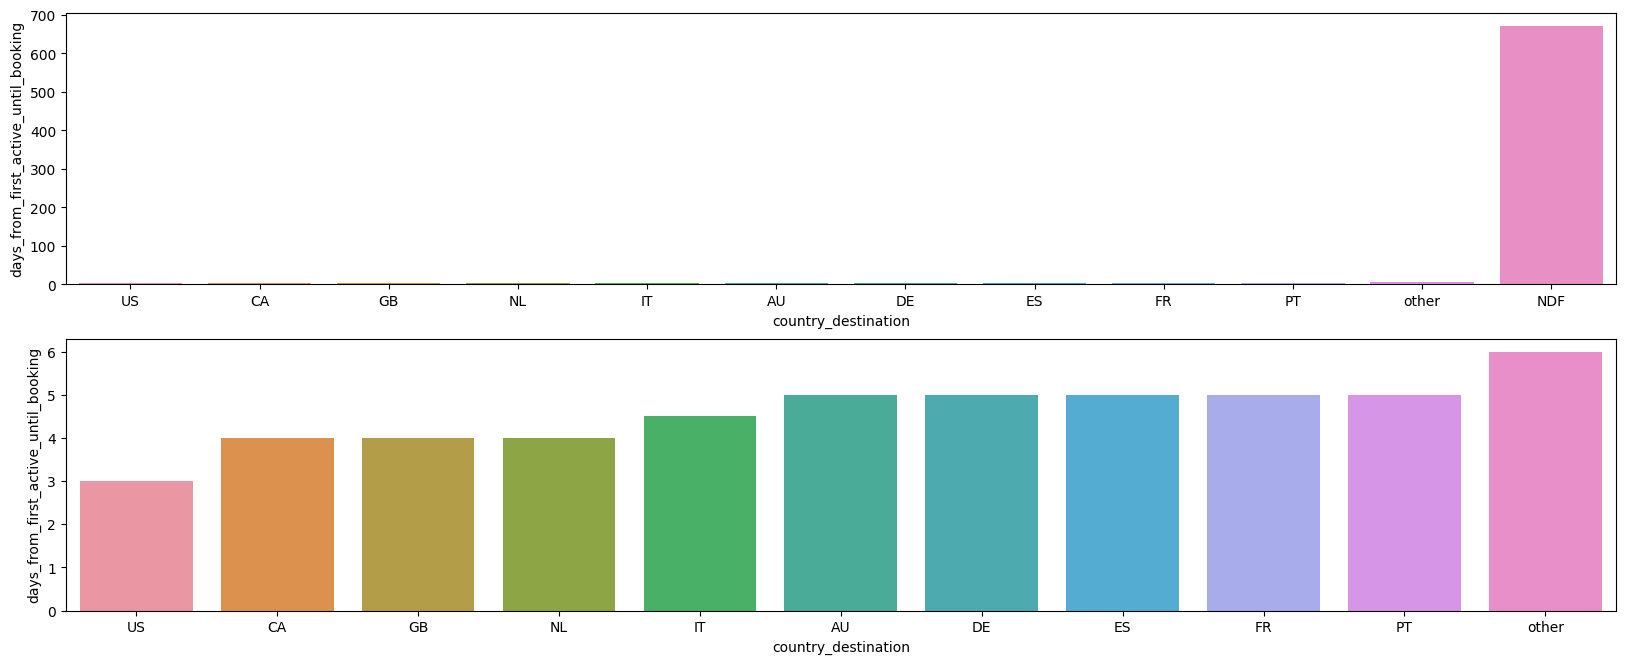

In [49]:
plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
aux01 = df5[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values('days_from_first_active_until_booking'))

# remove outlier
plt.subplot(3, 1, 2)
aux02 = df5[df5['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values('days_from_first_active_until_booking'))

**H2.** Os usuários levem até 3 dias, em média, para fazer o cadastro no site em todos os destinos.

**Verdadeira.** Os usuários levam até 3 dias, em média para realizar o cadastro no site em todos os destinos

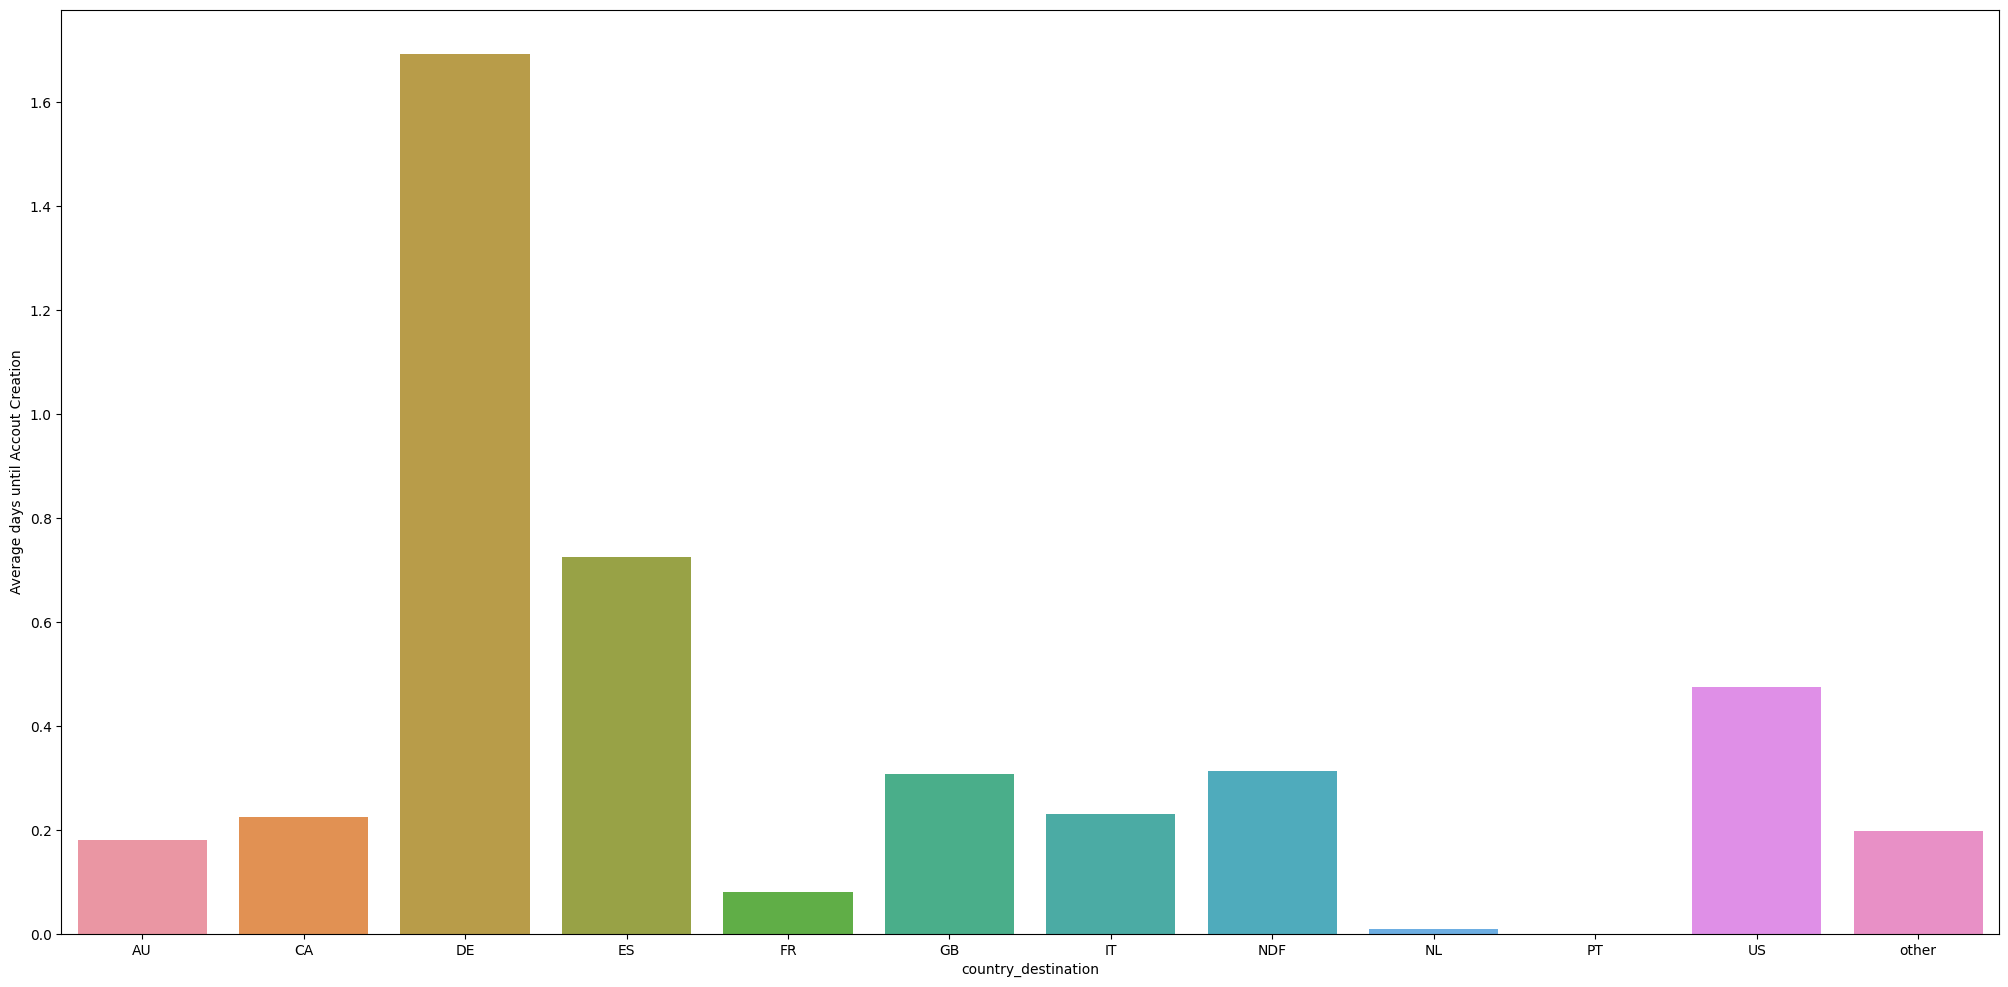

In [50]:
plt.figure(figsize=(25, 12))
aux01 = df5[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created' , data=aux01);
plt.ylabel('Average days until Accout Creation');

**H3.** O numero de reservas do Airbnb cresce ou decresce ao longo do tempo?

**Depende.**

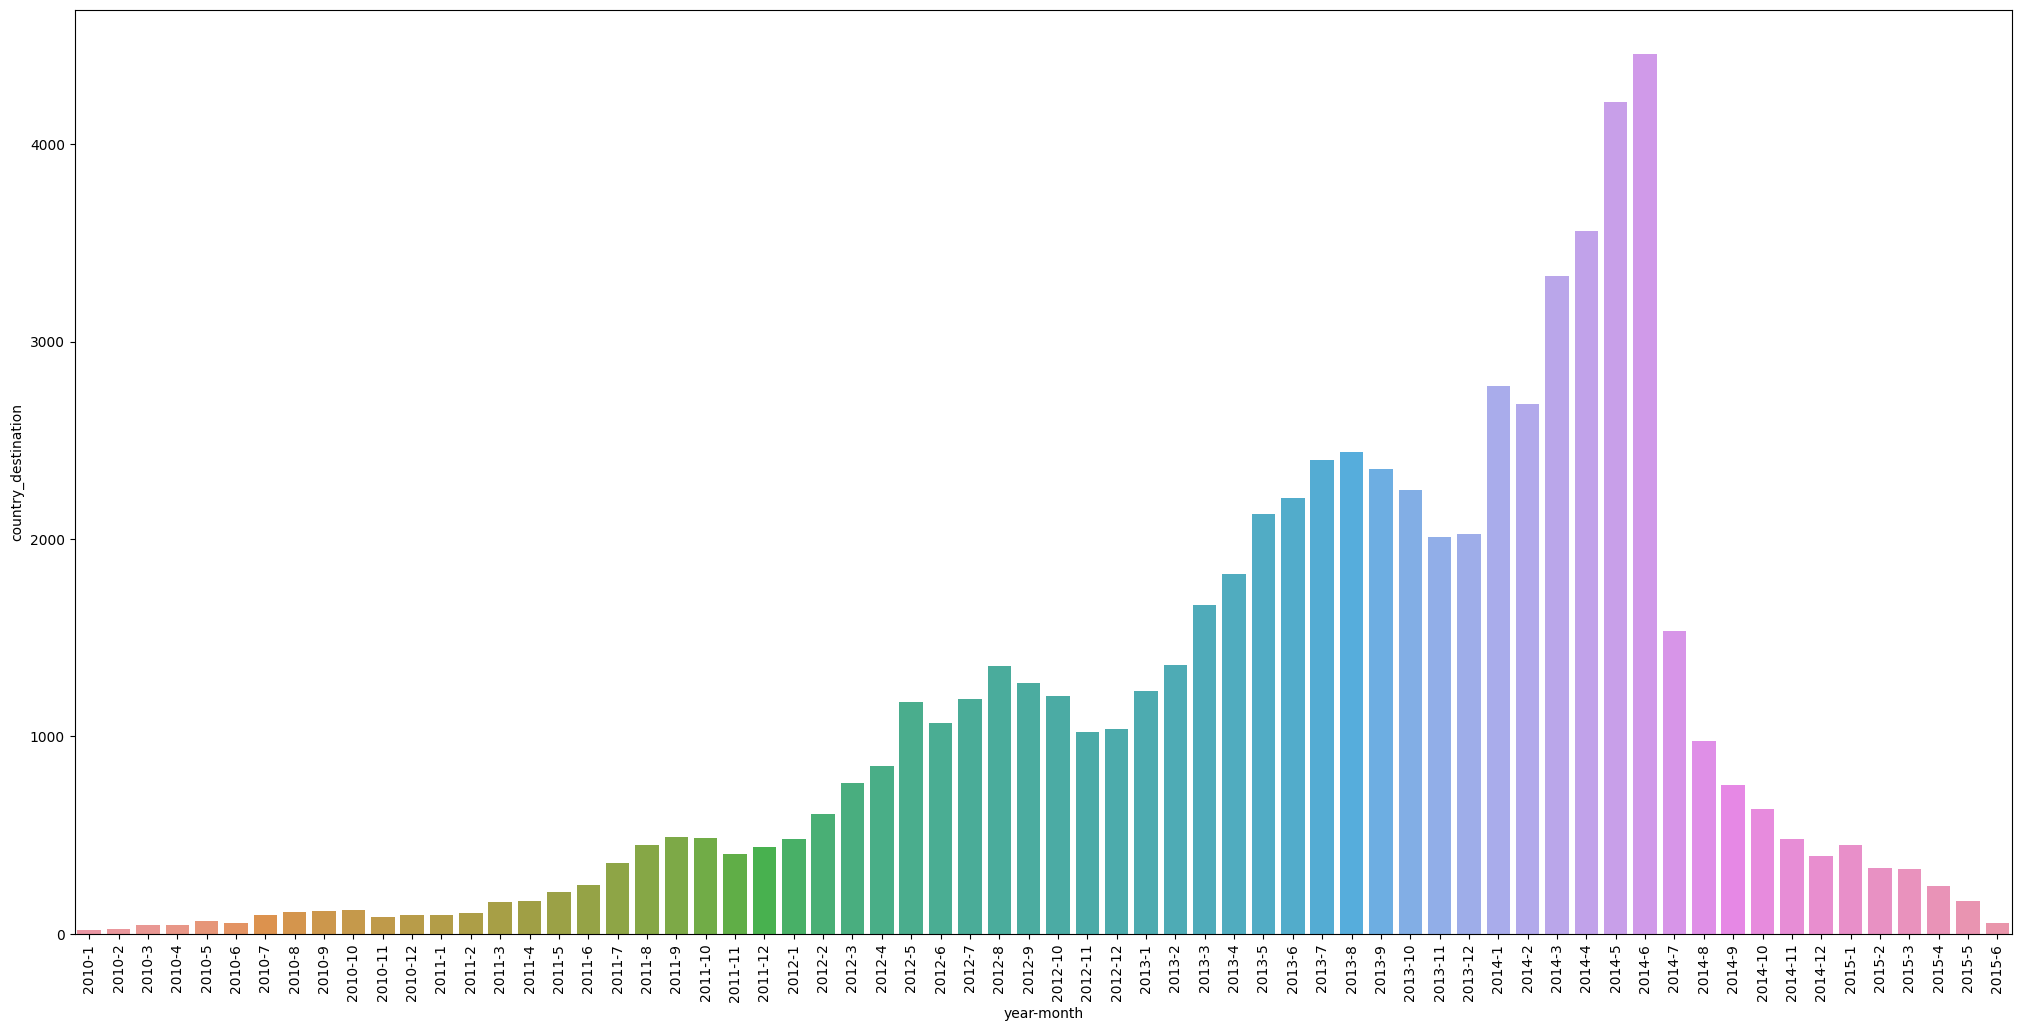

In [51]:
plt.figure(figsize=(25,12))
aux01 = df5[df5['country_destination'] != 'NDF']
aux01 = aux01[['year_first_booking', 'month_first_booking', 'country_destination']]\
                .groupby(['year_first_booking', 'month_first_booking'])\
                .count() \
                .reset_index()

aux01['year-month'] = aux01.apply(lambda x: str(x['year_first_booking']) + '-' + str(x['month_first_booking']), axis=1)

sns.barplot(x='year-month', y='country_destination', data=aux01);
plt.xticks(rotation=90);

**H4.** O numero de reservas total cresce 10% ao ano em todos os anos.

**Falsa.** O numero de reservas total cresce 10% ao ao apenas entre 2011 e 2013.

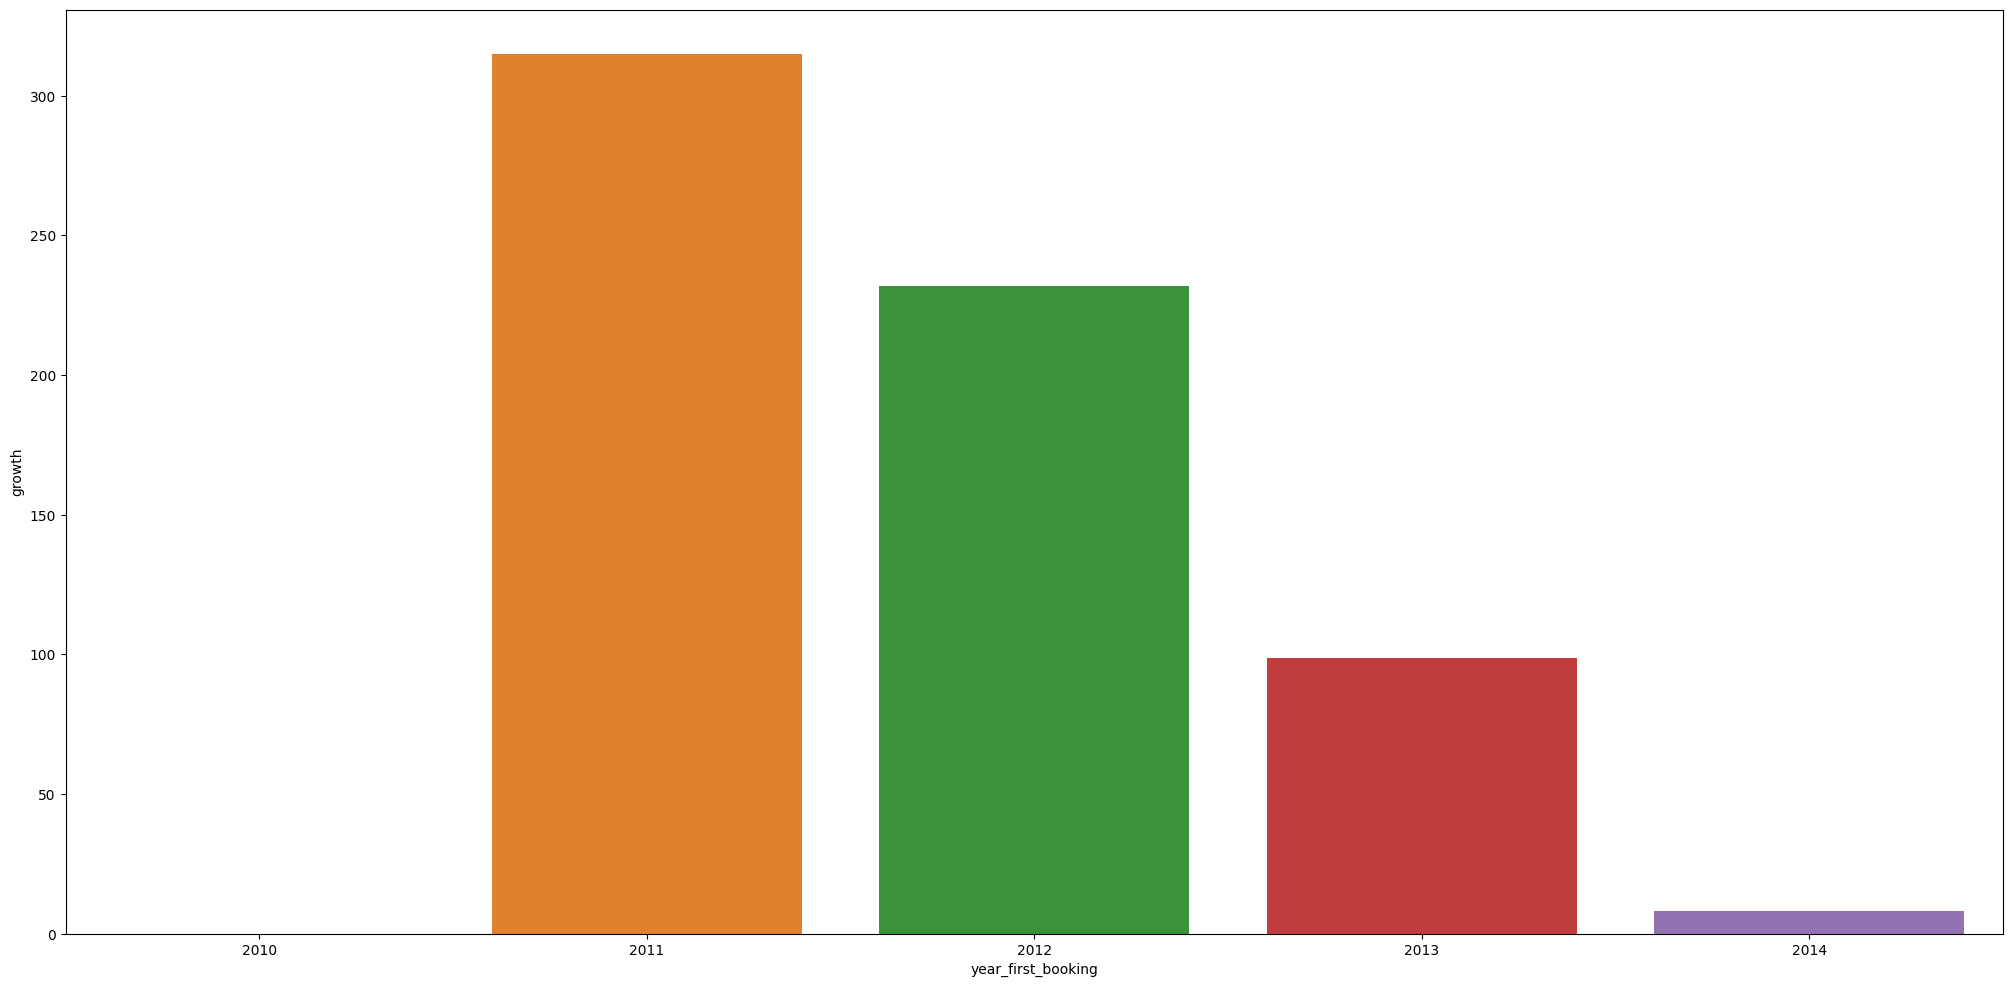

In [52]:
plt.figure(figsize=(25, 12))
aux01 = df5[(df5['country_destination'] != 'NDF') & (df5['year_first_booking'] < 2015)]
aux01 = aux01[['year_first_booking', 'country_destination']].groupby('year_first_booking').count().reset_index()

aux01['growth'] = 100*aux01['country_destination'].pct_change()

sns.barplot(x='year_first_booking', y='growth', data=aux01);

**H5.** Todos os canais de Marketing geram pelo menos 10% de reservas para todos os destinos.

**False.** Nem todos os canais de Marketing geram pelo menos 10% de reservas para todos os destinos.

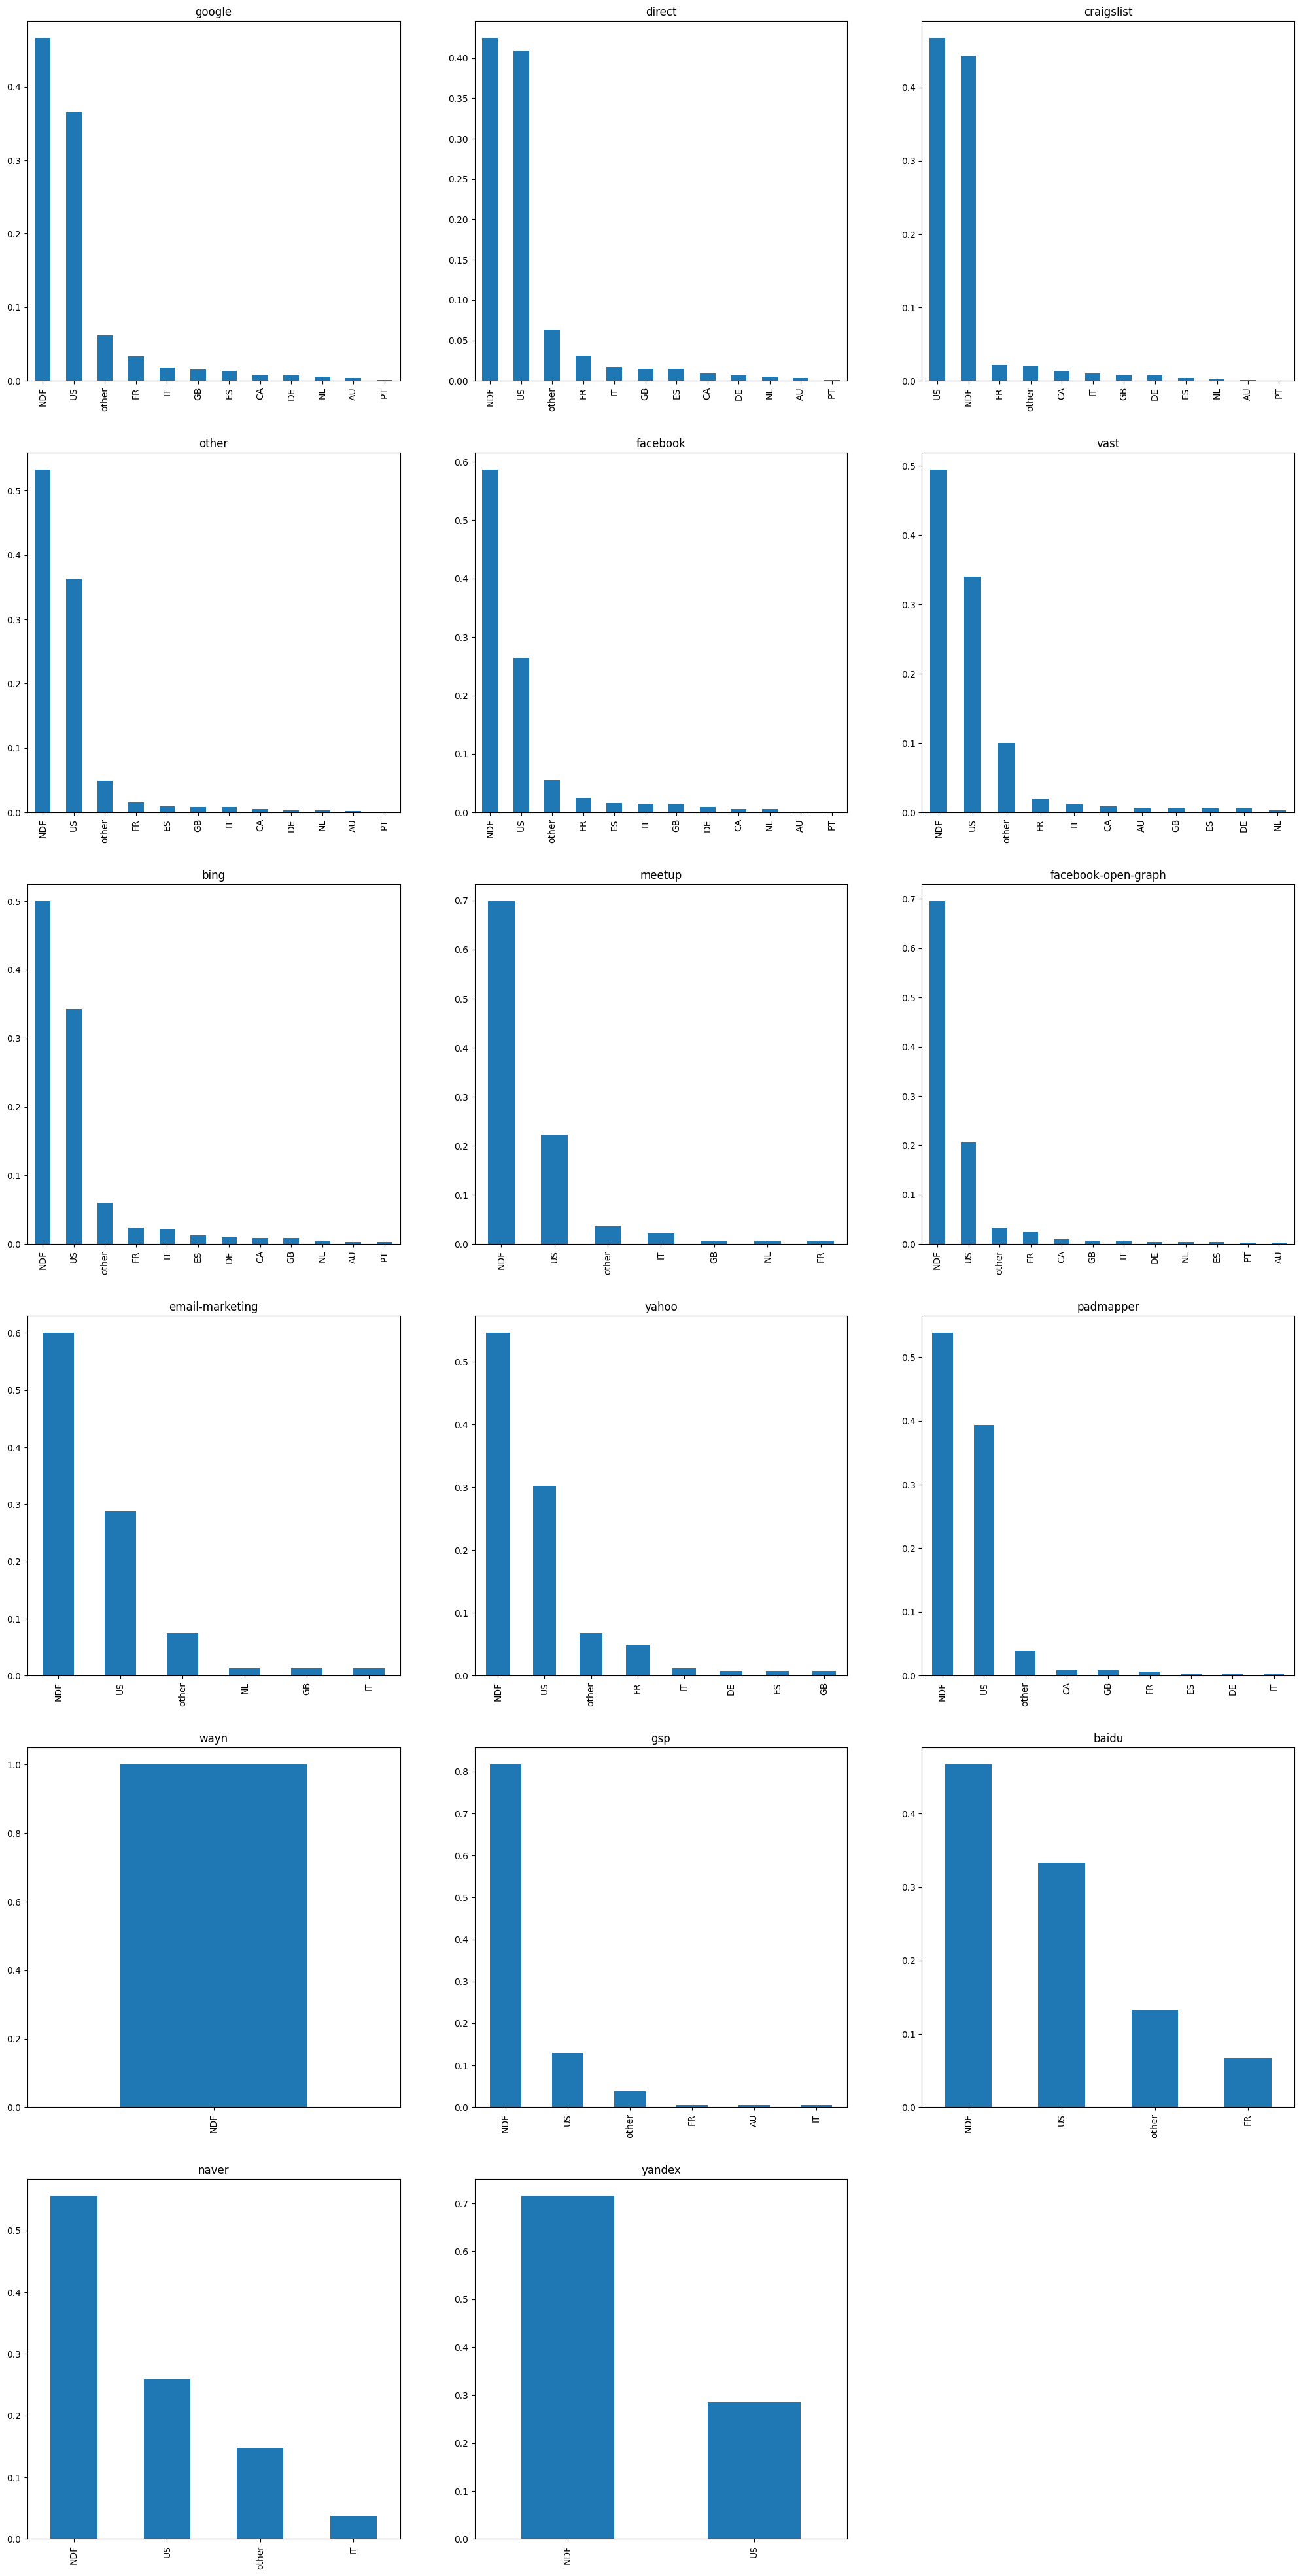

In [53]:
affiliate_list = df5['affiliate_provider'].drop_duplicates().tolist()

plt.figure(figsize=(25, 50))
for i in range(len(affiliate_list)):
    plt.subplot(6, 3, i+1)
    df5[df5['affiliate_provider'] == affiliate_list[i]]['country_destination'].value_counts(normalize=True).plot.bar();
    plt.title(affiliate_list[i]);

**H06.** O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**False.** O Volume de reservas aumenta durante o verão entre os anos de 2010 até 2013.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

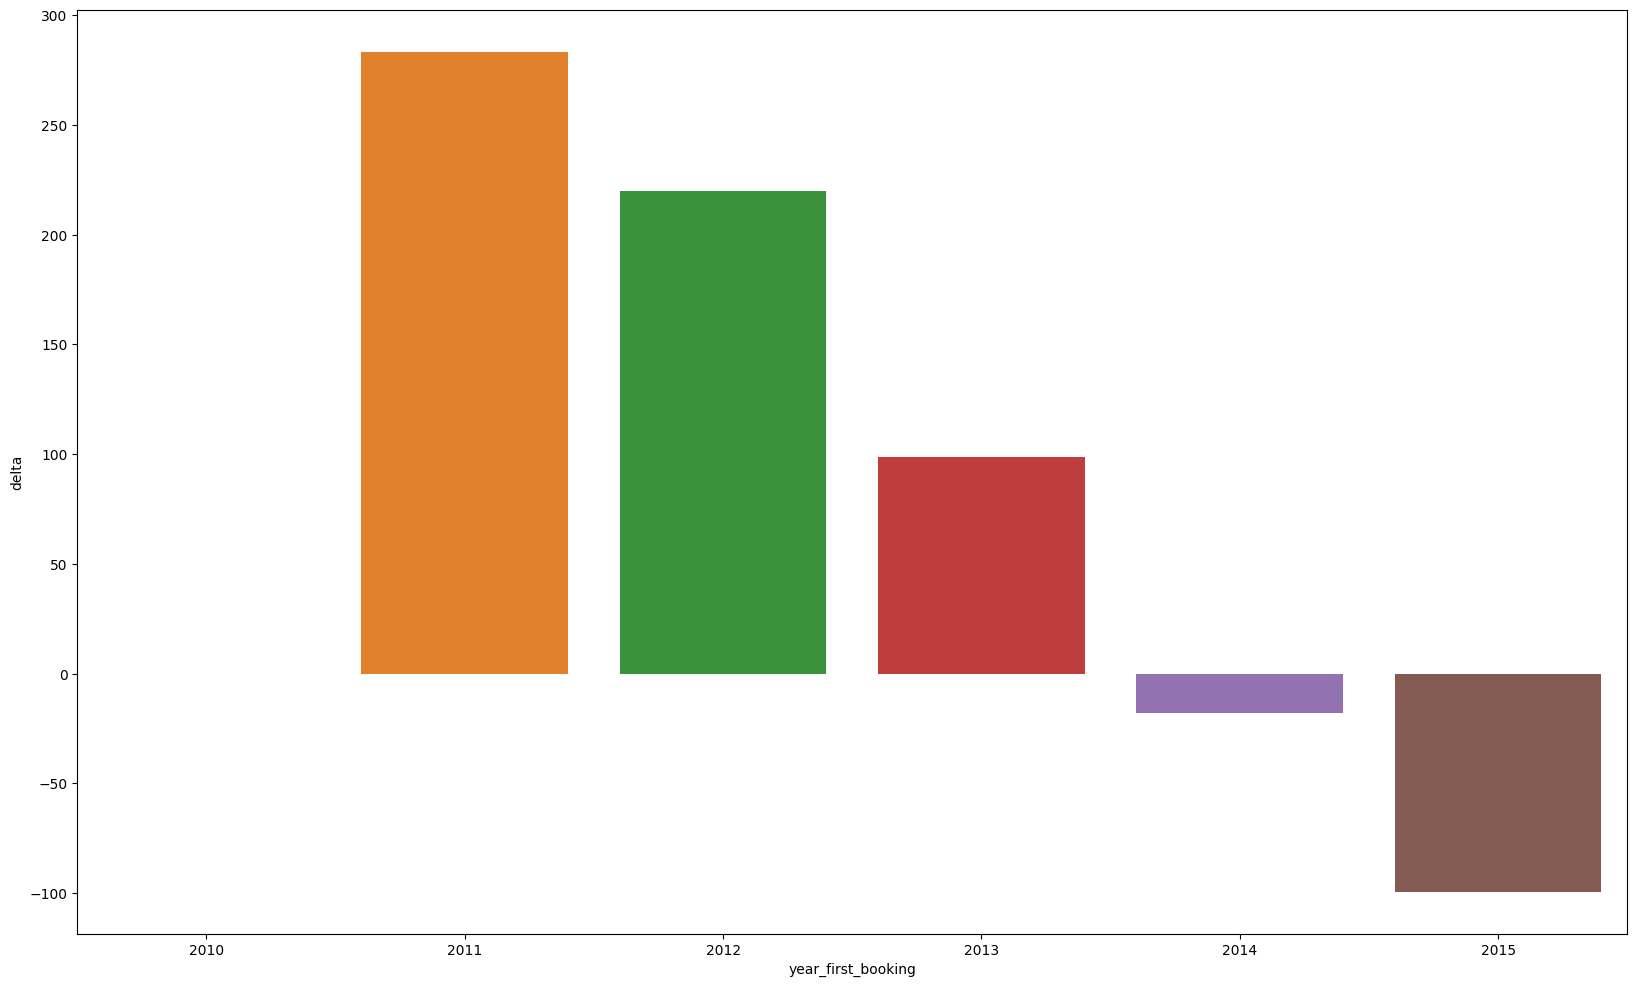

In [54]:
aux01 = df5[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby(['year_first_booking', 'month_first_booking', 'country_destination']). \
                size().reset_index().rename(columns={0:'count'})

# select only summer
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9])) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

plt.figure(figsize=(20,12))
sns.barplot(x='year_first_booking', y='delta', data=aux02)

**Outras Hipóteses para validar**

H04. Usuários do sexo feminino fazem 10% mais reservas para países fora dos USA. 

H05. O canal de Marketing Google representa 40% das reservas para países fora dos USA. 

H06. O destino dos USA representam mais de 20% em todos os canais. 

H07. A idade média das pessoas é de 35 anos em todos os destinos. 

H08. A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90% 

H09. O número de reservas do Airbnb é crescente ou decrescente ao longo dos anos? 

H10. O número de reservas do Airbnb é crescente ao longo dos anos.

## 5.2. Impacto das variáveis

### 5.2.1. Análise Univariada

In [55]:
profile = ProfileReport(df5, title='Airbnb Booking')
#profile.to_notebook_iframe()
# profile.to_file(output_file='airbnb_booking_statistics_after_cleaning.html')

### 5.2.2. Análise Bivariada

### 5.2.3. Análise Multivariada

In [56]:
#### Devido a Alta correlação vamos remover as proximas variáveis.
##################################################################

# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# Remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# Remove: year_first_active

# month_first_active x month_account_created
# Remove: month_first_active

# day_first_active x day_account_created
# Remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# Remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# Remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# Remove: month_first_booking

# month_account_created x week_of_year_account_created
# Remove: month_account_created

# year_first_booking x year_account_created
# Remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# Remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# Remove: affiliate_provider

# first_device_type x first_browser
# Remove: first_browser

#first_device_type x sigup_app
#Remove: first_device_type

In [57]:
# Atributos que serão removidos devido a alta correlação.
cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
        'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language']        
        

# 6.0. Preparação dos dados

In [58]:
df6 = df5.drop(cols, axis=1)
df6.shape

(122636, 17)

## 6.1. Encoding

In [59]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [60]:
# Age - StandarScaler
df6['age'] = ss.fit_transform(df6[['age']].values)

# signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

# days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = rs.fit_transform(df6[['days_from_first_active_until_account_created']].values)

# days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform(df6[['days_from_account_created_until_first_booking']].values)

# year_account_created - MinMax Scaler
df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)

## 6.2. Rescalling

In [61]:
te = TargetEncoder()
ohe = OneHotEncoder(use_cat_names=True)

# https://stackoverflow.com/questions/56338847/how-to-give-column-names-after-one-hot-encoding-with-sklearn

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [62]:
# gender - One Hot Encoder
df6 = pd.concat([df6, ohe.fit_transform(df6['gender'])], axis=1)

# signup_method - One Hot Encoder
df6 = pd.concat([df6, ohe.fit_transform(df6['signup_method'])], axis=1)

# signup_app - One Hot Encoder
df6 = pd.concat([df6, ohe.fit_transform(df6['signup_app'])], axis=1)

df6 = df6.drop(['gender', 'signup_method', 'signup_app'], axis=1)

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [63]:
# affiliate_channel - Target Encoder
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform(df6[['affiliate_channel']].values, df6['country_destination'].map(c))

# first_affiliate_tracked - Target Encoder
df6['first_affiliate_tracked'] = te.fit_transform(df6[['first_affiliate_tracked']].values, df6['country_destination'].map(c))

## 6.3. Transformation

In [64]:
# week_of_year_account_created
df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply(lambda x: np.cos(x * (2*np.pi/52)))

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# day_account_created
df6['day_account_created_sin'] = df6['day_account_created'].apply(lambda x: np.sin(x * (2*np.pi/31)))
df6['day_account_created_cos'] = df6['day_account_created'].apply(lambda x: np.cos(x * (2*np.pi/31)))

# day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# 7.0. Seleção Features

In [65]:
# Remove features que são inúteis para o modelo.
# cols_drop = []
# df7 = df6.drop(cols_drop, axis=1)

df7 = df6.copy()

C:\Users\laurivan\AppData\Local\Temp\ipykernel_836\2207447028.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df7.corr(method='pearson'), annot=True)


<AxesSubplot:>

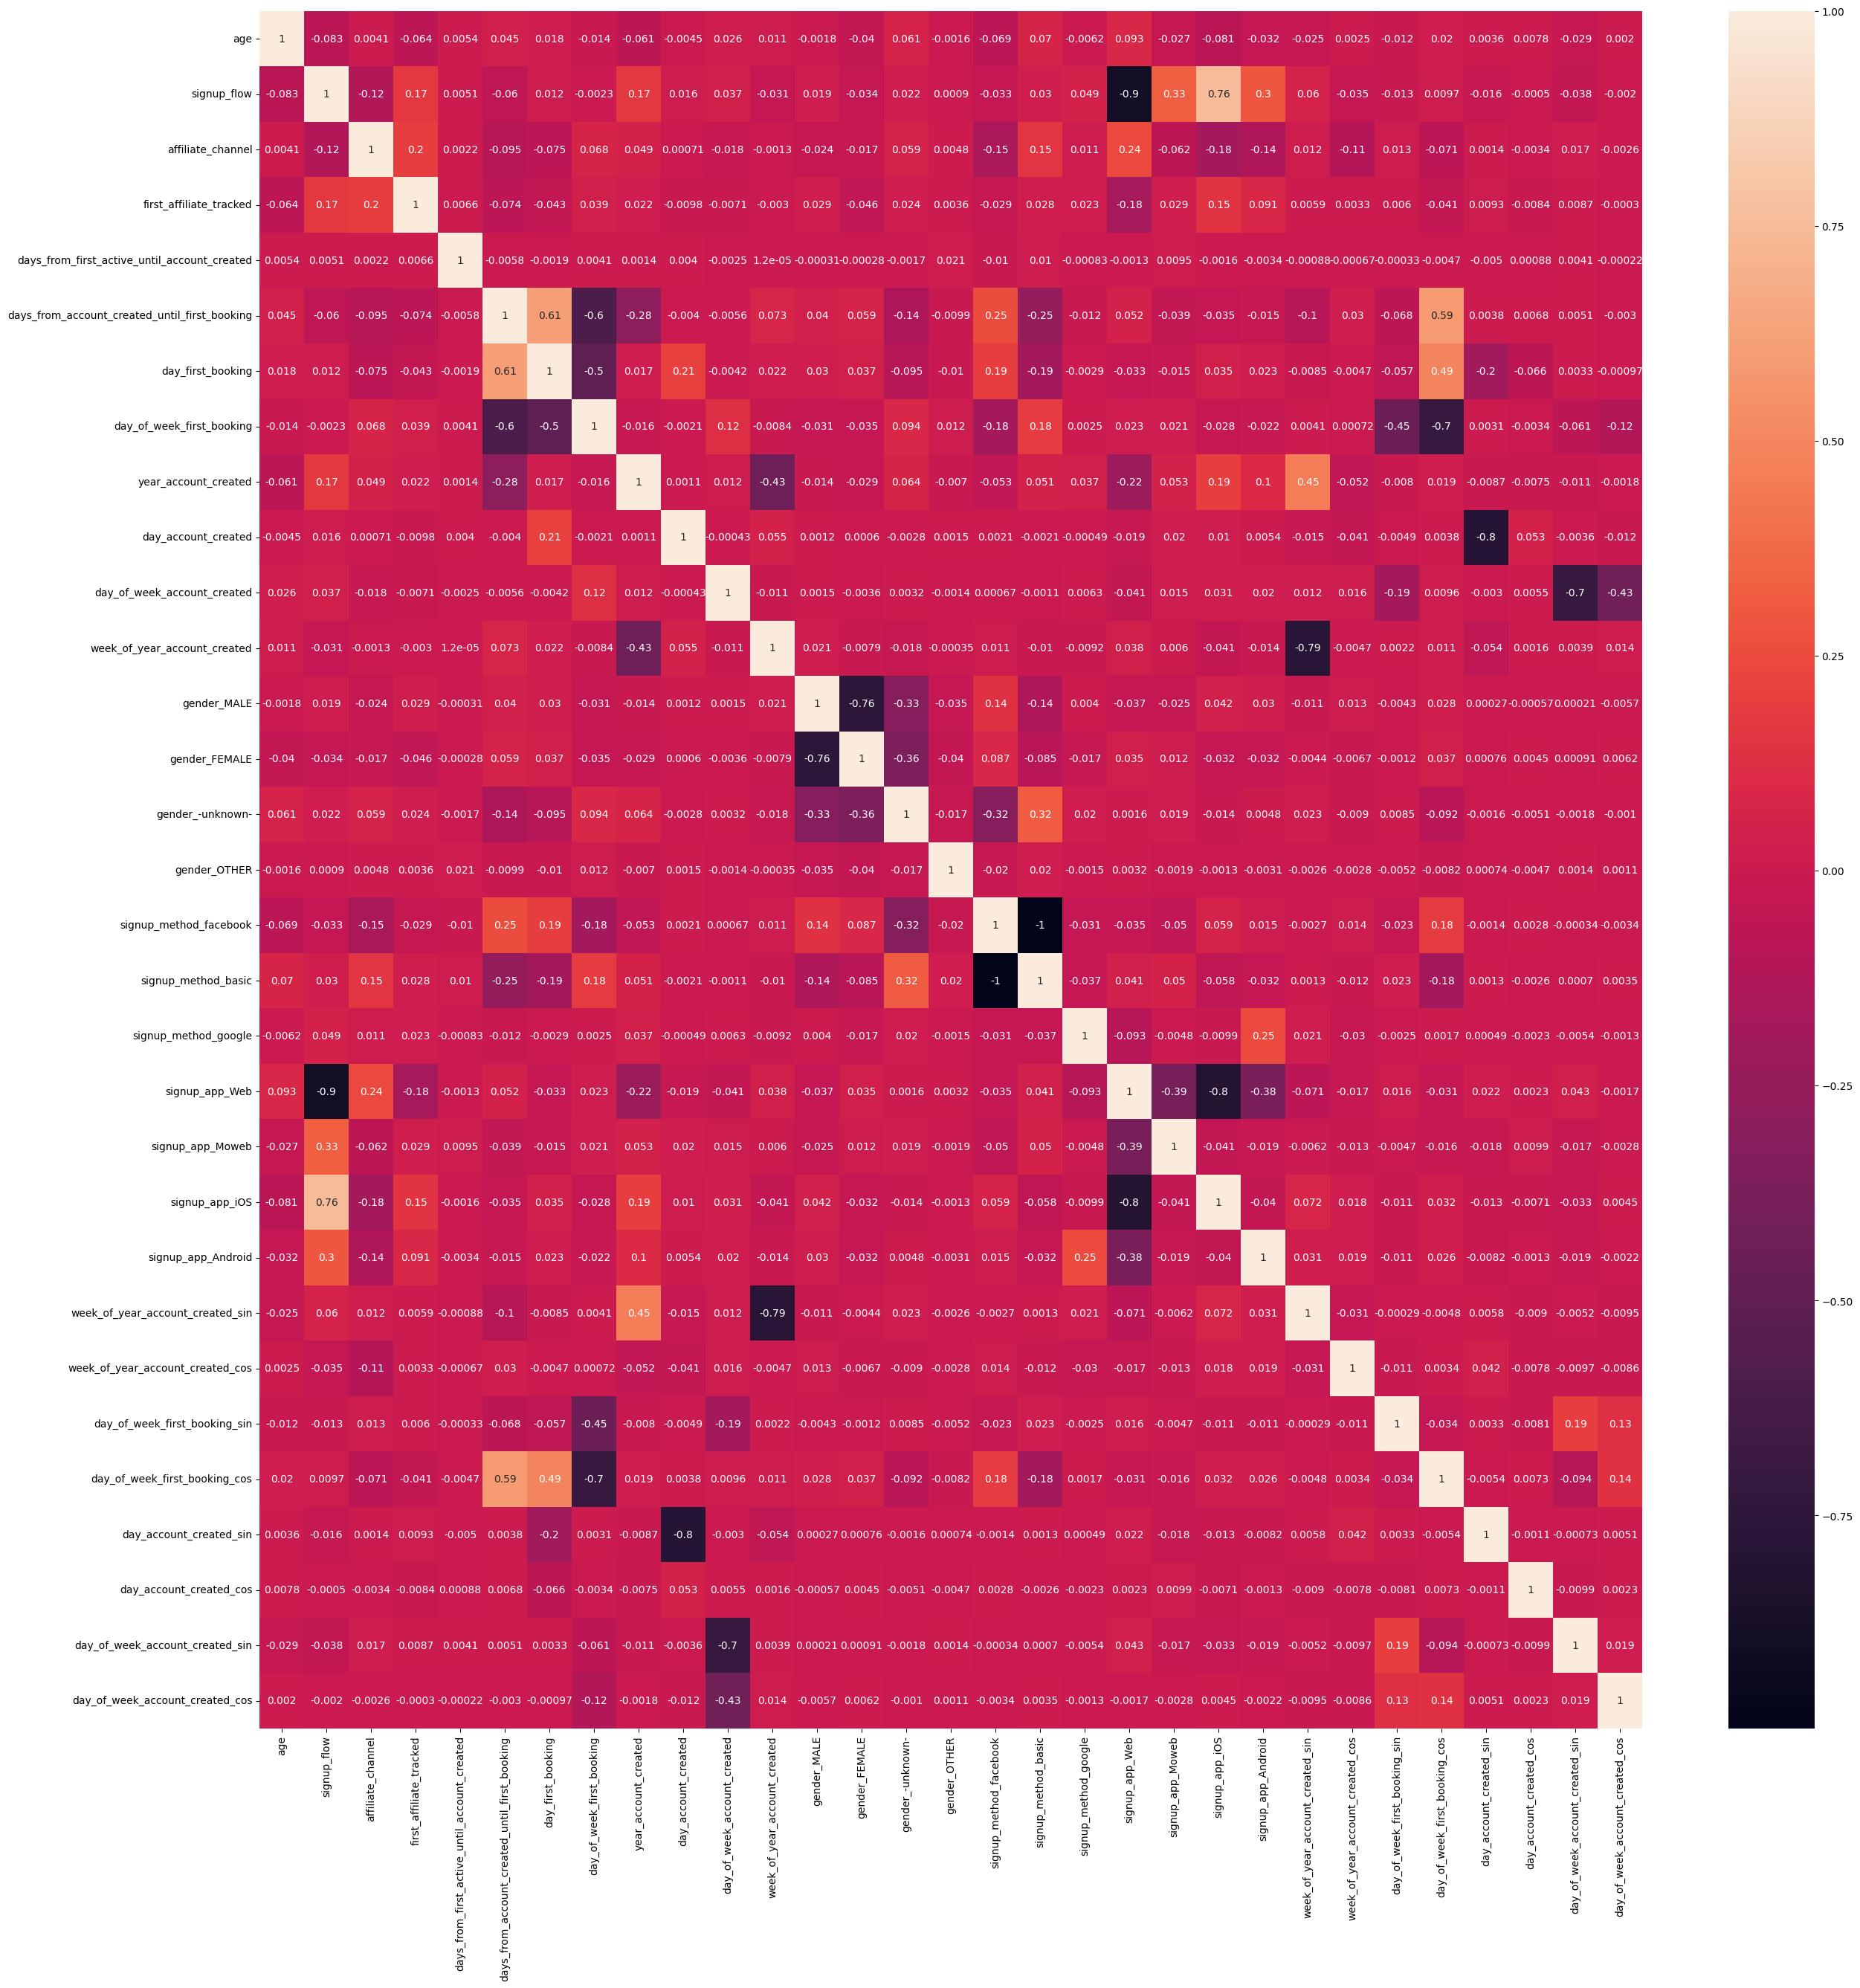

In [131]:
plt.figure(figsize=(30,30))
sns.heatmap(df7.corr(method='pearson'), annot=True)

In [66]:
X = df7.drop('country_destination', axis=1)
y = df7['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

# 8.0. Machine Learning

In [85]:
from sklearn.model_selection import cross_validate
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score, accuracy_score, cohen_kappa_score

def evaluate(model, X, y, cv, nome='', historico=None):
    scoring = {'balanced_accuracy_score' : make_scorer(balanced_accuracy_score),
            'accuracy_score': make_scorer(accuracy_score),
            'cohen_kappa_score': make_scorer(cohen_kappa_score)}
            
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring#('f1_weighted', 'recall') #("f1_weighted", "recall", "precision",'accuracy', "balanced_accuracy"),
    )
    
    # print(cv_results)

    # f1_weighted = cv_results["test_f1_weighted"]
    # recall = cv_results["test_recall"]
    # precision = cv_results["test_precision"]
    accuracy = cv_results["test_accuracy_score"]
    balanced_accuracy = cv_results["test_balanced_accuracy_score"]
    cohen_kappa = cv_results["test_cohen_kappa_score"]

    print(
        # f"***Modelo: {list(model.named_steps.keys())[1]}***\n"
        # f"F1 Weighted: {f1_weighted.mean():.3f} +/- {f1_weighted.std():.3f}\n"
        # f"Recall:      {recall.mean():.3f} +/- {recall.std():.3f}\n"
        # f"Precision:   {precision.mean():.3f} +/- {precision.std():.3f}\n"
        # f"F1 ALL: {f1_weighted}\n"
        f"***Modelo: {nome}***\n"
        f"Accuracy          :   {accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
        f"Balanced Accuracy :   {balanced_accuracy.mean():.3f} +/- {balanced_accuracy.std():.3f}\n"
        f"Kappa Score      :   {cohen_kappa.mean():.3f} +/- {cohen_kappa.std():.3f}\n"
    )

    resultados = {
        'Modelo': nome,
        'accuracy_mean': accuracy.mean(),
        'accuracy_std': accuracy.std(),
        'balanced_accuracy_mean': balanced_accuracy.mean(),
        'balanced_accuracy_std': balanced_accuracy.std(),
        'kappa_score_mean': cohen_kappa.mean(),
        'kappa_score_std': cohen_kappa.std()
    }

    todos = pd.DataFrame(resultados, index=[0])
    
    if resultados != None:
        todos = pd.concat([todos, historico])
    
    return todos

# results = evaluate(model_xgb, x_train_xgb, y_train_le, 2, 'XGBoost')
# results

In [84]:
aa = pd.DataFrame(['1', '3'])
bb = pd.DataFrame(['0'])
pd.concat([aa, bb])



,0
0,1
1,3
0,0


In [95]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

FOLDS = 5

## 8.1. Baseline 

In [68]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list,  
                             weights=country_destination_weights,
                             k=k_num)
len(yhat_random)

24528

### 8.1.1 Baseline Performance

In [69]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy:{}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
# mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12))

Accuracy: 0.3612198303979126
Balanced Accuracy:0.08423119613188702
Kappa Score: 0.0020211823046669686
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        92
          CA       0.02      0.02      0.02       208
          DE       0.01      0.01      0.01       160
          ES       0.01      0.01      0.01       286
          FR       0.03      0.03      0.03       767
          GB       0.02      0.02      0.02       334
          IT       0.02      0.02      0.02       440
         NDF       0.45      0.45      0.45     11016
          NL       0.00      0.00      0.00       111
          PT       0.00      0.00      0.00        29
          US       0.39      0.39      0.39      9619
       other       0.05      0.05      0.05      1466

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



## XGBoost

In [96]:
x_train = x_train.astype('float')#.head()
x_test = x_test.astype('float')

In [71]:
features = x_train.columns
features[0:10]
x_train_xgb = x_train#[features]

In [97]:
le = pp.LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_train_le

model_xgb = xgb.XGBClassifier(random_state=42)

# Usando Cross validation
results = evaluate(model_xgb, x_train_xgb, y_train_le, FOLDS, 'XGBoost')
results

***Modelo: XGBoost***
Accuracy          :   0.838 +/- 0.000
Balanced Accuracy :   0.167 +/- 0.000
Kappa Score      :   0.722 +/- 0.000



,Modelo,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,kappa_score_mean,kappa_score_std
0,XGBoost,0.837577,0.000301,0.166737,0.000218,0.722012,0.000495


In [112]:
# import sklearn
# sklearn.metrics.get_scorer_names()


# Análise dos resultados sem cross validation

#Treino
model_xgb.fit(x_train_xgb, y_train_le)

# Predição
yhat_xgb = model_xgb.predict(x_test)

In [128]:
x_train.shape

(98108, 31)

Text(0.5, 0, 'Xgboost Feature Importance')

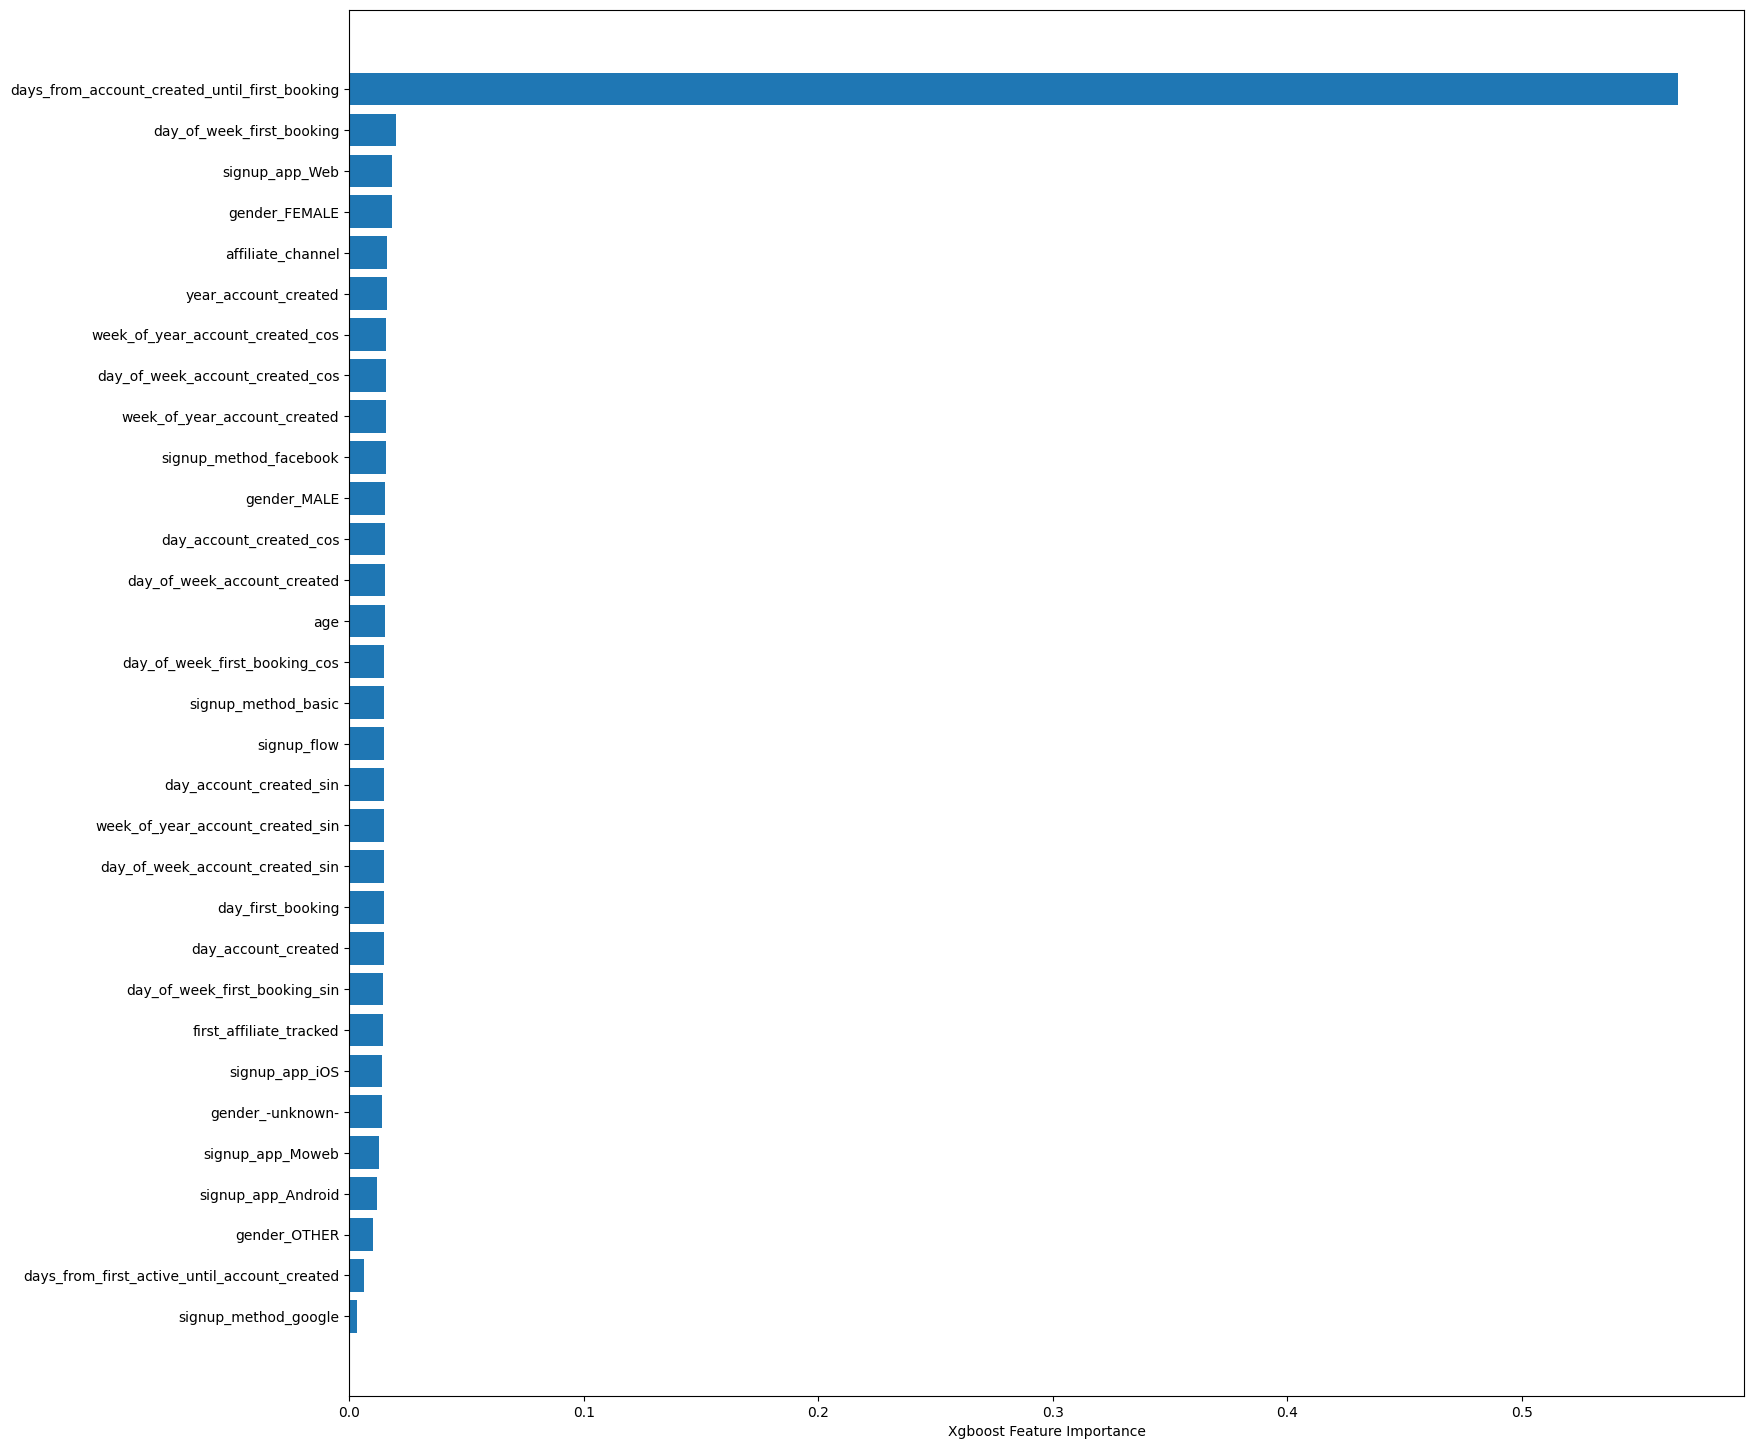

In [126]:
sorted_idx = model_xgb.feature_importances_.argsort()
x_train.columns[sorted_idx]
model_xgb.feature_importances_[sorted_idx]
fig = plt.figure(figsize=(18, 18))
plt.barh(x_train.columns[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Acurácia: 0.8405495759947815
Balanced Accuracy:0.1668961701868947
Kappa Score: 0.726421337980555


e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        92
          CA       0.00      0.00      0.00       208
          DE       0.00      0.00      0.00       160
          ES       0.00      0.00      0.00       286
          FR       0.00      0.00      0.00       767
          GB       0.00      0.00      0.00       334
          IT       0.00      0.00      0.00       440
         NDF       1.00      1.00      1.00     11016
          NL       0.00      0.00      0.00       111
          PT       0.00      0.00      0.00        29
          US       0.71      1.00      0.83      9619
       other       0.28      0.01      0.01      1466

    accuracy                           0.84     24528
   macro avg       0.17      0.17      0.15     24528
weighted avg       0.74      0.84      0.78     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

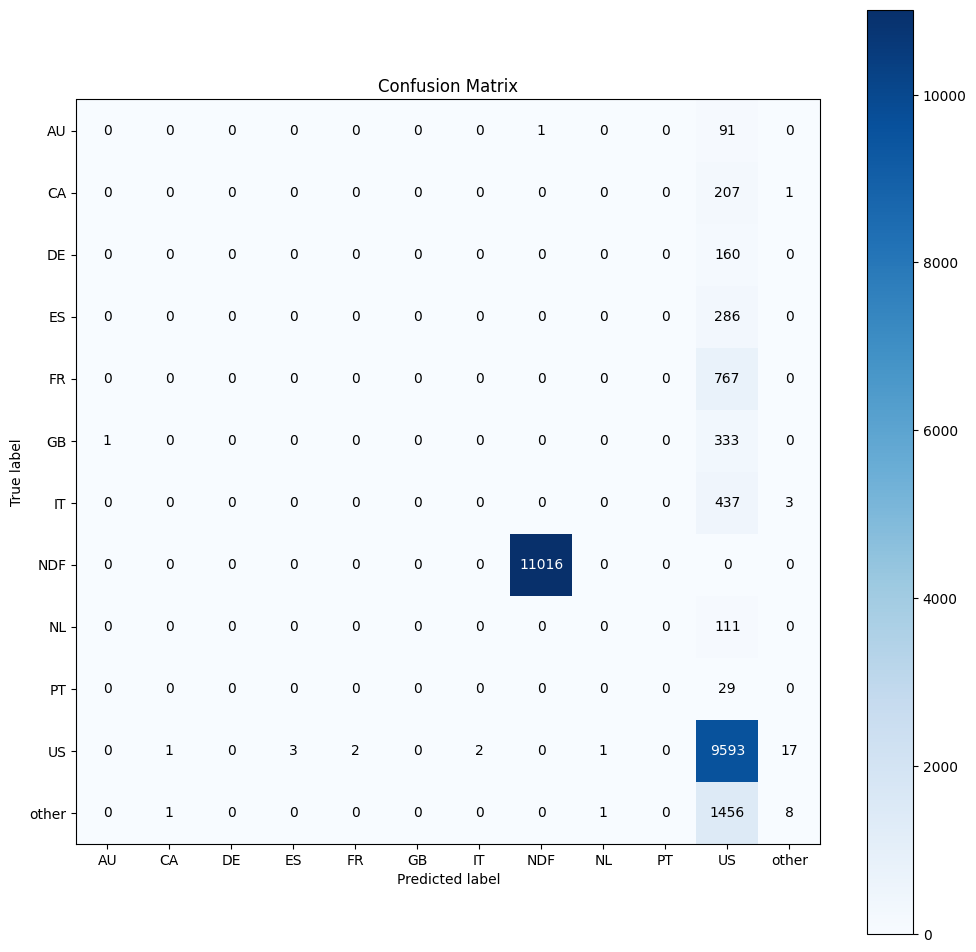

In [117]:

# y_test_le = le.fit_transform(y_test)

# y_test_le = le.inverse_transform(y_test_le)
yhat_xgb = le.inverse_transform(yhat_xgb)

y_test_le = y_test

# Acurácia
acc_xgb =m.accuracy_score(y_test_le, yhat_xgb)
print(f'Acurácia: {acc_xgb}')

# Balanced Accuray
balanced_acc_xgb = m.balanced_accuracy_score(y_test_le, yhat_xgb)
print('Balanced Accuracy:{}'.format(balanced_acc_xgb))

# Kappa
kappa_nn = m.cohen_kappa_score(y_test_le, yhat_xgb)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_le, yhat_xgb))

# Matriz de Confusão
mt.plot_confusion_matrix(y_test_le, yhat_xgb, normalize=False, figsize=(12,12))

In [ ]:
# import xgboost as xgb

# model_xgb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('XGBClassifier', xgb.XGBClassifier(random_state=42))
# ])

# # # treinando o modelo
# # model_xgb.fit(X_train, y_train)

# # if AMBIENTE_DEV:
# #     yhat_xgb = model_xgb.predict(X_test)

# #     # Gerando resultados
# #     print(classification_report(yhat_tree, y_test));

# #     # resultados.update({'xgb_train': model_xgb.score(X_train, y_train)})
# #     # resultados.update({'xgb_test': model_xgb.score(X_test, y_test)})

# #     resultados = resultado('XGBClassifier', 
# #             model_xgb.score(X_train, y_train), 
# #             model_xgb.score(X_test, y_test),
# #             classification_report(yhat_xgb, y_test),
# #             resultados)

## LightGBM

In [98]:
le = pp.LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_train_le

model_lgb = lgb.LGBMClassifier(random_state=42)

# # Treino
# model_lgb.fit(x_train, y_train_le)

# # Predição
# yhat_lgb = model_lgb.predict(x_test)

# y_test_le = le.fit_transform(y_test)

results = evaluate(model_lgb, x_train, y_train_le, FOLDS, 'LGBM', results)
results

***Modelo: LGBM***
Accuracy          :   0.837 +/- 0.000
Balanced Accuracy :   0.167 +/- 0.001
Kappa Score      :   0.722 +/- 0.000



,Modelo,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,kappa_score_mean,kappa_score_std
0,LGBM,0.837373,0.000187,0.166908,0.000576,0.721702,0.000297
0,XGBoost,0.837577,0.000301,0.166737,0.000218,0.722012,0.000495


## Random Forest

In [99]:
model_rf = RandomForestClassifier(random_state=42)

# res_rf = evaluate(model_rf, x_train, y_train_le, 5, 'Random Forest', res_lgbm)
results = evaluate(model_rf, x_train, y_train_le, FOLDS, 'Random Forest', results)
results

***Modelo: Random Forest***
Accuracy          :   0.820 +/- 0.001
Balanced Accuracy :   0.166 +/- 0.000
Kappa Score      :   0.697 +/- 0.002



,Modelo,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,kappa_score_mean,kappa_score_std
0,Random Forest,0.819984,0.001439,0.166331,0.000294,0.696979,0.002178
0,LGBM,0.837373,0.000187,0.166908,0.000576,0.721702,0.000297
0,XGBoost,0.837577,0.000301,0.166737,0.000218,0.722012,0.000495


## Regressão Logistica

In [100]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42)

results = evaluate(model_lr, x_train, y_train_le, FOLDS, 'Logistic Regression', results)
results

e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

***Modelo: Logistic Regression***
Accuracy          :   0.832 +/- 0.001
Balanced Accuracy :   0.165 +/- 0.000
Kappa Score      :   0.712 +/- 0.001



e:\Programas\instalacao\anaconda3\envs\pa000\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Modelo,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,kappa_score_mean,kappa_score_std
0,Logistic Regression,0.831910,0.000671,0.165242,0.000139,0.711733,0.001167
0,Random Forest,0.819984,0.001439,0.166331,0.000294,0.696979,0.002178
0,LGBM,0.837373,0.000187,0.166908,0.000576,0.721702,0.000297
0,XGBoost,0.837577,0.000301,0.166737,0.000218,0.722012,0.000495


## ExtraTreesClassifier

In [101]:
model_et = ExtraTreesClassifier(random_state=42)

results = evaluate(model_et, x_train, y_train_le, FOLDS, 'ExtraTreesClassifier', results)
results

***Modelo: ExtraTreesClassifier***
Accuracy          :   0.814 +/- 0.001
Balanced Accuracy :   0.166 +/- 0.000
Kappa Score      :   0.689 +/- 0.001



,Modelo,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,kappa_score_mean,kappa_score_std
0,ExtraTreesClassifier,0.814296,0.000685,0.165995,0.000407,0.688656,0.000996
0,Logistic Regression,0.831910,0.000671,0.165242,0.000139,0.711733,0.001167
0,Random Forest,0.819984,0.001439,0.166331,0.000294,0.696979,0.002178
0,LGBM,0.837373,0.000187,0.166908,0.000576,0.721702,0.000297
0,XGBoost,0.837577,0.000301,0.166737,0.000218,0.722012,0.000495


## GradientBoostingClassifier

In [103]:
#### NÃO SERA EXECUTADO POIS É MUITO DEMORADO.

# model_gb = GradientBoostingClassifier(random_state=42)

# results = evaluate(model_gb, x_train, y_train_le, FOLDS, 'GradientBoostingClassifier', results)
# results

***Modelo: GradientBoostingClassifier***
Accuracy          :   0.837 +/- 0.000
Balanced Accuracy :   0.166 +/- 0.000
Kappa Score      :   0.722 +/- 0.000



,Modelo,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,kappa_score_mean,kappa_score_std
0,GradientBoostingClassifier,0.837444,0.000163,0.166443,0.000011,0.721790,0.000245
0,ExtraTreesClassifier,0.814296,0.000685,0.165995,0.000407,0.688656,0.000996
0,Logistic Regression,0.831910,0.000671,0.165242,0.000139,0.711733,0.001167
0,Random Forest,0.819984,0.001439,0.166331,0.000294,0.696979,0.002178
0,LGBM,0.837373,0.000187,0.166908,0.000576,0.721702,0.000297
0,XGBoost,0.837577,0.000301,0.166737,0.000218,0.722012,0.000495


## 8.9. Neural Network MLP

In [ ]:
# ohe = pp.OneHotEncoder()
# ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
x_train.shape
x_train = x_train.astype('int')

In [ ]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

# Definição Modelo
model = ml.Sequential()
model.add(l.Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Treino
model.fit(x_train, y_train_nn, epochs=100, verbose=True)

### 8.9.1 NN Performance

In [ ]:
x_test = x_test.astype('int')

In [ ]:
# Predição
pred_nn = model.predict(x_test)

# Inverte predição
yhat_nn = ohe.inverse_transform(pred_nn)

y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

In [ ]:
# Acurácia
acc_nn =m.accuracy_score(y_test_nn, yhat_nn)
print(f'Acurácia: {acc_nn}')

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy:{}'.format(balanced_acc_nn))

# Kappa
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Matriz de Confusão
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

# Acurácia: 0.8412426614481409
# Balanced Accuracy:0.16665800325744187
# Kappa Score: 0.7273389222364827

Acurácia: 0.7094976164283096

Balanced Accuracy:0.09153183873284591

Kappa Score: 0.004007337133695277

### 8.9.1 NN Performance - Cross-Validation

In [ ]:
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print(f'Fold {i}/{num_folds}')

    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # Definição Modelo
    model = ml.Sequential()
    model.add(l.Dense(512, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Treino modelo
    model.fit(x_train_fold, y_train_fold_nn, epochs=50, batch_size=32, verbose=0)

    # Predição
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # Ajusta os dados com reshape
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # Métricas
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1   


In [ ]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list), 2), 
                                                  np.round(np.std(balanced_acc_list), 4)))
print('Avg Kappa: {} +/- {}'.format(np.round(np.mean(kappa_acc_list), 4), 
                                      np.round(np.std(kappa_acc_list), 4)))

Avg Balanced Accuracy: 0.09 +/- 0.0003

Avg Kappa: 0.003 +/- 0.0018